In [267]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import datetime

In [2]:
import pandarallel as pdl
pdl.pandarallel.initialize()

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 88 workers


In [271]:
train_df = pd.read_csv('dataset/train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])

In [272]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [273]:
def plus_1_day(s):
    return s + datetime.timedelta(days=1)

In [274]:
# 如果违约,还款日期为due_date的后一天
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(
    lambda x: x['repay_date'] if x['repay_date'] != '\\N' else plus_1_day(x['due_date']), axis=1
)

In [275]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [276]:
# 如果违约,还款金额为0
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')

In [277]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299


In [278]:
# 错误做法,用还款日-成立日
# train_df['label'] = (train_df['repay_date'] - train_df['auditing_date']).dt.days
# train_df['label'].value_counts(sort=False)

In [279]:
# 设定label
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

In [280]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,label
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498,1
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000,-1
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299,6


In [281]:
train_df['label'].value_counts(sort=False)

 0     408187
 1     121085
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 24      3922
 25      3934
 26      3930
 27      4102
 28      4677
 29      5645
 30      9865
 31      8368
-1     117192
Name: label, dtype: int64

In [282]:
train_df['label'].nunique()

33

In [283]:
# 为什么要把-1换作32:方便分类编号和日期对应
# train_df.loc[train_df['repay_amt'] == -1, 'label'] = 32 错误写法
train_df['label'].replace(-1, 32, inplace=True)

In [284]:
clf_labels = train_df['label'].values

In [285]:
clf_labels.shape

(1000000,)

In [286]:
amt_labels = train_df['repay_amt'].values

In [287]:
del train_df['label'], train_df['repay_amt'], train_df['repay_date']

In [288]:
amt_labels

array([ 72.1167, 258.7045,   0.    , ..., 258.7045, 140.7993, 180.9695],
      dtype=float32)

In [289]:
train_due_amt_df = train_df[['due_amt']]

In [290]:
train_num = train_df.shape[0]

In [291]:
test_df = pd.read_csv('dataset/test.csv', parse_dates=['auditing_date', 'due_date'])

In [292]:
test_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


# 不删除user_id,我觉得还有用

In [293]:
# sub = test_df[['listing_id', 'auditing_date', 'due_amt', 'due_date']]
sub = test_df[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'due_date']]

In [294]:
sub.head()

,user_id,listing_id,auditing_date,due_amt,due_date
0,498765,5431438,2019-03-12,138.5903,2019-04-12
1,34524,5443211,2019-03-15,208.0805,2019-04-15
2,821741,5461707,2019-03-22,421.2097,2019-04-22
3,263534,5472320,2019-03-26,212.6537,2019-04-26
4,238853,5459750,2019-03-21,817.4593,2019-04-21


In [295]:
test_df.shape

(130000, 5)

In [296]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [297]:
df.shape

(1130000, 5)

In [298]:
df_listing_id = df['listing_id']

In [299]:
listing_info_df = pd.read_csv('dataset/listing_info.csv')

In [300]:
listing_info_df.head()

,user_id,listing_id,auditing_date,term,rate,principal
0,316610,1556649,2017-11-26,9,7.6,4800
1,62002,1556633,2017-11-26,6,7.6,4000
2,192135,1556629,2017-11-26,12,8.0,8660
3,487382,1556628,2017-11-26,9,7.6,4780
4,235186,1556627,2017-11-26,9,7.6,1480


In [301]:
train_df.set_index('listing_id').head()

,user_id,auditing_date,due_date,due_amt
listing_id,,,,
3163926,748147,2018-04-25,2018-05-25,72.1167
3698760,672952,2018-06-09,2018-07-09,258.7045
2355665,404196,2018-02-18,2018-03-18,307.9270
1994522,342769,2018-01-13,2018-02-13,252.9809
3602352,828139,2018-06-01,2018-07-01,107.6503


In [302]:
listing_info_df.set_index('listing_id').loc[3163926]

user_id              748147
auditing_date    2018-04-25
term                      9
rate                    7.2
principal               630
Name: 3163926, dtype: object

In [303]:
del listing_info_df['user_id'], listing_info_df['auditing_date']

In [304]:
listing_info_df.head()

,listing_id,term,rate,principal
0,1556649,9,7.6,4800
1,1556633,6,7.6,4000
2,1556629,12,8.0,8660
3,1556628,9,7.6,4780
4,1556627,9,7.6,1480


# 新加几个特征

In [305]:
listing_info_df['平均每月借款金额'] = listing_info_df['principal'] / listing_info_df['term']

In [306]:
listing_info_df.head()

,listing_id,term,rate,principal,平均每月借款金额
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [307]:
listing_info_df.term.value_counts()

6     2393016
12    1372299
9     1302618
3      416958
Name: term, dtype: int64

In [308]:
df = df.merge(listing_info_df, on='listing_id', how='left')

In [309]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000


In [310]:
def chu(s):
    s= s.strip()
    a, b = s[s.find("'")+1:s.find("']")].split('/')
    df_s = s[:s.find('[')]
    print(' = ' + df_s+"['"+a+"'] / " + df_s + "['" + b + "']")
    
def jian(s):
    s= s.strip()
    a, b = s[s.find("'")+1:s.find("']")].split('-')
    df_s = s[:s.find('[')]
    print(' = ' + df_s+"['"+a+"'] - " + df_s + "['" + b + "']")

In [311]:
# 新增cate特征
cate_cols2 = []

In [312]:
df['总还款金额'] = df['term'] * df['due_amt']
df['总利息'] = df['总还款金额'] - df['principal']
df['每月利息'] = df['总利息'] / df['term']
df['总利息/总还款金额'] = df['总利息'] / df['总还款金额']
df['平均每月借款金额/due_amt'] = df['平均每月借款金额'] / df['due_amt']
df['总利息/principal'] = df['总利息'] / df['principal']
df['总利息/总还款金额'] = df['总利息'] / df['总还款金额']
df['还款期限日'] = (df['due_date'] - df['auditing_date']).dt.days
df['首期平均每日还款'] = df['due_amt'] / df['还款期限日']
df['due_date星期几'] = df['due_date'].dt.dayofweek
df['auditing_date星期几'] = df['auditing_date'].dt.dayofweek
df['due_date是当月第几日'] = df['due_date'].dt.day
df['auditing_date是当月第几日'] = df['auditing_date'].dt.day

In [313]:
cate_cols2.append('due_date星期几')
cate_cols2.append('auditing_date星期几')

In [314]:
s = "df['总利息/总还款金额']"
chu(s)

 = df['总利息'] / df['总还款金额']


In [315]:
s = "df['总还款金额-principal']"
jian(s)

 = df['总还款金额'] - df['principal']


In [316]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限日,首期平均每日还款,due_date星期几,auditing_date星期几,due_date是当月第几日,auditing_date是当月第几日
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,25,25
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,18,18
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,13,13
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,1,1


# user_info

In [317]:
user_info_df = pd.read_csv('dataset/user_info.csv', parse_dates=['reg_mon', 'insertdate'])

In [318]:
user_info_df.head()

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04-01,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05-01,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05-01,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07-01,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03-01,男,23,c05,c05,c05193,2018-04-02


In [319]:
user_info_df.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

In [320]:
user_info_df['user_id'].value_counts().head()

670044    3
567844    3
799738    3
66268     3
336069    3
Name: user_id, dtype: int64

下面这行是选最新数据,但是原则上我们用的数据必须是在auditing_date之前的数据,所以最好别这么简单地去重了

In [321]:
# user_info_df = user_info_df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('user_id').reset_index(drop=True)

通过一个时间对比控制不使用未来数据

In [322]:
# def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id', check_nan='gender'):
    # df3 = df.merge(df2, on=on, how='left')
    # if df3[check_nan].isna().sum() > 0:
    #     print('存在空值,需要小心检查一下')
    #     return df3
    
    # 去除掉未来时间的数据
    # df4 = df3[(df3['auditing_date']>=df3[df2_time])|(df3[check_nan].isna())]
    
    # 使用剩下数据中最新的数据
    # df5 = df4.sort_values(df2_time, ascending=False).drop_duplicates('listing_id')
    
    # 防止一条数据都没有
    # df6 = df.merge(df5, on=df.columns.tolist(), how='outer')
    # return df6

In [323]:
def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id'):
    df3 = df.merge(df2, on=on, how='left')
    # 不必选出有空值的行，最后一步能顾及到（乐）
    df4 = df3[(df3['auditing_date']>=df3[df2_time])]
    df5 = df.merge(df4, on=df.columns.tolist(), how='left')
    return df5

In [324]:
df = merge_before_auditing(df, user_info_df, df2_time='info_insert_date', on='user_id')

In [325]:
df = df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

这块还没做特征

In [326]:
df.shape

(1130000, 28)

In [327]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# user_taglist

In [328]:
user_tag_df = pd.read_csv('dataset/user_taglist.csv', parse_dates=['insertdate'])

In [329]:
user_tag_df.head(10)

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02
5,257271,3688|141|1059|1616|247|3527|2788|2431|2706|234...,2018-06-20
6,286758,4073|5474|1583|449|244|676|2306|3755|440|3688|...,2018-03-12
7,279566,2266|1330|3744|424|2018|1318|436|2410|956|2785...,2018-07-15
8,842520,2018|4288|3133|5733|2212|181|942|2072|3440|165...,2018-06-07
9,374058,440|4185|2264|4381|1137|1059|3760|2649|620|530...,2018-04-11


In [330]:
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)

user_tag_df也不能都用最新的数据

In [331]:
df = merge_before_auditing(df, user_tag_df, df2_time='tag_insert_date', on='user_id')

In [332]:
df = df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [333]:
# user_tag_df = user_tag_df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('user_id').reset_index(drop=True)

In [334]:
df.shape

(1130000, 30)

In [335]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# user_repay_logs

In [336]:
repay_log_df = pd.read_csv('dataset/user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])

In [337]:
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)

In [338]:
repay_log_df.sort_values(by='due_date',ascending=False).head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
2544012,882692,5482798,1,2019-04-30,576.0161,2019-03-30,576.0161
2117425,785337,5481718,1,2019-04-30,144.3660,2019-03-30,144.3660
1459650,882692,5482750,1,2019-04-30,195.7588,2019-03-30,195.7588
2143042,920572,5481601,1,2019-04-30,107.0008,2019-03-30,107.0008
2339237,882692,5482707,1,2019-04-30,195.7588,2019-03-30,195.7588


In [339]:
# repay: 0[expired] 1[on time]
repay_log_df['repay'] = repay_log_df['repay_date'].astype('str').apply(lambda x: 1 if x != '2200-01-01' else 0)

In [340]:
repay_log_df.head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1


In [341]:
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days

In [342]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1
6,237430,4058618,1,2018-08-23,212.5250,2200-01-01,212.5250,0,-66240
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0


In [343]:
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

In [344]:
# TODO: parallelize
repay_log_df['repay_date'] = repay_log_df[['repay_date','due_date']].apply(
    lambda x: x['repay_date'] if x['repay_date']!= datetime.datetime(2200,1,1) else x['due_date'], axis=1)

In [345]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1
6,237430,4058618,1,2018-08-23,212.5250,2018-08-23,212.5250,0,-1
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0


In [346]:
# 保留'repay_date'
# for f in ['listing_id', 'order_id','due_date', 'repay_date', 'repay_amt']:
for f in ['listing_id', 'order_id', 'due_date','repay_amt']:
    del repay_log_df[f]

In [347]:
repay_log_df = repay_log_df.rename(columns={'due_amt':'log_due_amt', 'repay_date':'log_repay_date'})

In [348]:
repay_log_df.head()

,user_id,log_due_amt,log_repay_date,repay,early_repay_days
0,748483,528.6365,2018-01-28,1,1
1,369368,385.5078,2018-07-22,1,12
2,749102,338.5357,2017-12-11,1,31
3,385257,1106.1967,2018-03-02,1,1
4,648677,385.5078,2018-07-04,1,19


In [349]:
df.shape

(1130000, 30)

In [350]:
 df = merge_before_auditing(df, repay_log_df, df2_time='log_repay_date', on='user_id')

In [351]:
group = df.groupby('listing_id', as_index=False)

In [352]:
group.ngroups

1130000

In [353]:
df = df.merge(
    group['repay'].agg({'repay_mean': 'mean'}), on='listing_id', how='left'
)

In [354]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限日,首期平均每日还款,due_date星期几,auditing_date星期几,due_date是当月第几日,auditing_date是当月第几日,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,taglist,tag_insert_date,log_due_amt,log_repay_date,repay,early_repay_days,repay_mean
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,25,25,2017-12-01,男,21,c20,c20,c20089,2018-04-24,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,102.1022,2018-04-24,1.0,28.0,1.0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,133.9311,2018-06-05,1.0,1.0,1.0
2,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,945.0062,2017-12-10,1.0,0.0,1.0
3,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,258.7045,2018-06-07,1.0,2.0,1.0
4,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,133.9311,2018-05-11,1.0,1.0,1.0


In [355]:
df = df.merge(
    group['early_repay_days'].agg({
        'early_repay_days_max': 'max', 'early_repay_days_median': 'median', 'early_repay_days_sum': 'sum',
        'early_repay_days_mean': 'mean', 'early_repay_days_std': 'std'
    }), on='listing_id', how='left'
)

In [356]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限日,首期平均每日还款,due_date星期几,auditing_date星期几,due_date是当月第几日,auditing_date是当月第几日,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,taglist,tag_insert_date,log_due_amt,log_repay_date,repay,early_repay_days,repay_mean,early_repay_days_max,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,25,25,2017-12-01,男,21,c20,c20,c20089,2018-04-24,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,102.1022,2018-04-24,1.0,28.0,1.0,28.0,28.0,28.0,28.0,NaN
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,133.9311,2018-06-05,1.0,1.0,1.0,12.0,1.0,16.0,3.2,4.969909
2,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,945.0062,2017-12-10,1.0,0.0,1.0,12.0,1.0,16.0,3.2,4.969909
3,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,258.7045,2018-06-07,1.0,2.0,1.0,12.0,1.0,16.0,3.2,4.969909
4,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,9,9,2017-09-01,男,37,c14,c17,c17250,2018-06-04,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,133.9311,2018-05-11,1.0,1.0,1.0,12.0,1.0,16.0,3.2,4.969909


In [357]:
df = df.merge(
    group['log_due_amt'].agg({
        'due_amt_max': 'max', 'due_amt_min': 'min', 'due_amt_median': 'median',
        'due_amt_mean': 'mean', 'due_amt_sum': 'sum', 'due_amt_std': 'std',
        'due_amt_skew': 'skew', 'due_amt_kurt': kurtosis, 'due_amt_ptp': np.ptp
    }), on='listing_id', how='left'
)

In [358]:
df = df.drop_duplicates('listing_id').reset_index(drop=True)

In [359]:
del df['repay'], df['early_repay_days'], df['log_due_amt'],df['log_repay_date']

In [360]:
df.shape

(1130000, 45)

In [361]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

In [362]:
cate_cols = ['gender', 'cell_province', 'id_province', 'id_city']

In [363]:
# 这个lgb应该有参数可以直接传 lgb.train(categorical_feature=cate_cols)
for f in cate_cols:
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique())))).astype('int32')

In [364]:
df['due_amt_per_days'] = df['due_amt'] / (train_df['due_date'] - train_df['auditing_date']).dt.days


In [365]:
date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']


In [366]:
for f in date_cols:
    if f in ['reg_mon', 'info_insert_date', 'tag_insert_date']:
        df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    if f in ['auditing_date', 'due_date', 'info_insert_date', 'tag_insert_date']:
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek

In [367]:
df.drop(columns=date_cols, axis=1, inplace=True)

In [368]:
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

In [369]:
tag_cv = CountVectorizer(min_df=10, max_df=0.9).fit_transform(df['taglist'])

In [101]:
tag_cv

<1130000x5977 sparse matrix of type '<class 'numpy.int64'>'
	with 53801401 stored elements in Compressed Sparse Row format>

In [370]:
del df['user_id'], df['listing_id'], df['taglist']

In [371]:
# 也可以用lgb.train(categorical_features=cate_cols)
df = pd.get_dummies(df, columns=cate_cols)

In [394]:
df.columns

Index(['due_amt', 'term', 'rate', 'principal', '平均每月借款金额', '总还款金额', '总利息',
       '每月利息', '总利息/总还款金额', '平均每月借款金额/due_amt',
       ...
       'id_city_346', 'id_city_347', 'id_city_348', 'id_city_349',
       'id_city_350', 'id_city_351', 'id_city_352', 'id_city_353',
       'id_city_354', 'id_city_355'],
      dtype='object', length=471)

In [104]:
df = sparse.hstack((df.values, tag_cv), format='csr', dtype='float32')

In [105]:
train_values, test_values = df[:train_num], df[train_num:]

In [106]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
clf = LGBMClassifier(
    n_jobs=87,
    learning_rate=0.05,
    n_estimators=10000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    random_state=2019
)
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()

    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df.iloc[val_idx]

    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        early_stopping_rounds=100, verbose=5
    )
    # shape = (-1, 33)
    val_pred_prob_everyday = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt['due_amt'].values * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += clf.predict_proba(test_values, num_iteration=clf.best_iteration_) / skf.n_splits

    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))

0 fold...
Training until validation scores don't improve for 100 rounds.
[5]	valid_0's multi_logloss: 2.95534	valid_1's multi_logloss: 2.95794
[10]	valid_0's multi_logloss: 2.71768	valid_1's multi_logloss: 2.72256
[15]	valid_0's multi_logloss: 2.56756	valid_1's multi_logloss: 2.57469
[20]	valid_0's multi_logloss: 2.46264	valid_1's multi_logloss: 2.472
[25]	valid_0's multi_logloss: 2.38504	valid_1's multi_logloss: 2.39661
[30]	valid_0's multi_logloss: 2.32602	valid_1's multi_logloss: 2.33988
[35]	valid_0's multi_logloss: 2.28016	valid_1's multi_logloss: 2.29634
[40]	valid_0's multi_logloss: 2.24389	valid_1's multi_logloss: 2.2624
[45]	valid_0's multi_logloss: 2.21477	valid_1's multi_logloss: 2.2357
[50]	valid_0's multi_logloss: 2.1911	valid_1's multi_logloss: 2.21451
[55]	valid_0's multi_logloss: 2.17164	valid_1's multi_logloss: 2.19761
[60]	valid_0's multi_logloss: 2.15545	valid_1's multi_logloss: 2.18398
[65]	valid_0's multi_logloss: 2.14183	valid_1's multi_logloss: 2.17301
[70]	valid

[135]	valid_0's multi_logloss: 2.05187	valid_1's multi_logloss: 2.12644
[140]	valid_0's multi_logloss: 2.04803	valid_1's multi_logloss: 2.12576
[145]	valid_0's multi_logloss: 2.04426	valid_1's multi_logloss: 2.12518
[150]	valid_0's multi_logloss: 2.04062	valid_1's multi_logloss: 2.12471
[155]	valid_0's multi_logloss: 2.03706	valid_1's multi_logloss: 2.12428
[160]	valid_0's multi_logloss: 2.03358	valid_1's multi_logloss: 2.1239
[165]	valid_0's multi_logloss: 2.03022	valid_1's multi_logloss: 2.12355
[170]	valid_0's multi_logloss: 2.02694	valid_1's multi_logloss: 2.12331
[175]	valid_0's multi_logloss: 2.02373	valid_1's multi_logloss: 2.12308
[180]	valid_0's multi_logloss: 2.02056	valid_1's multi_logloss: 2.12287
[185]	valid_0's multi_logloss: 2.01747	valid_1's multi_logloss: 2.12268
[190]	valid_0's multi_logloss: 2.01439	valid_1's multi_logloss: 2.12252
[195]	valid_0's multi_logloss: 2.01138	valid_1's multi_logloss: 2.12236
[200]	valid_0's multi_logloss: 2.00847	valid_1's multi_logloss: 2

[210]	valid_0's multi_logloss: 2.00222	valid_1's multi_logloss: 2.12385
[215]	valid_0's multi_logloss: 1.99944	valid_1's multi_logloss: 2.12377
[220]	valid_0's multi_logloss: 1.99668	valid_1's multi_logloss: 2.12367
[225]	valid_0's multi_logloss: 1.99399	valid_1's multi_logloss: 2.1236
[230]	valid_0's multi_logloss: 1.99137	valid_1's multi_logloss: 2.12353
[235]	valid_0's multi_logloss: 1.98877	valid_1's multi_logloss: 2.12346
[240]	valid_0's multi_logloss: 1.98623	valid_1's multi_logloss: 2.1234
[245]	valid_0's multi_logloss: 1.98368	valid_1's multi_logloss: 2.12335
[250]	valid_0's multi_logloss: 1.98115	valid_1's multi_logloss: 2.12334
[255]	valid_0's multi_logloss: 1.97866	valid_1's multi_logloss: 2.12327
[260]	valid_0's multi_logloss: 1.97617	valid_1's multi_logloss: 2.12323
[265]	valid_0's multi_logloss: 1.97374	valid_1's multi_logloss: 2.12319
[270]	valid_0's multi_logloss: 1.97128	valid_1's multi_logloss: 2.12316
[275]	valid_0's multi_logloss: 1.96896	valid_1's multi_logloss: 2.

[280]	valid_0's multi_logloss: 1.96771	valid_1's multi_logloss: 2.12061
[285]	valid_0's multi_logloss: 1.96539	valid_1's multi_logloss: 2.12055
[290]	valid_0's multi_logloss: 1.96308	valid_1's multi_logloss: 2.1205
[295]	valid_0's multi_logloss: 1.96078	valid_1's multi_logloss: 2.12053
[300]	valid_0's multi_logloss: 1.9585	valid_1's multi_logloss: 2.12052
[305]	valid_0's multi_logloss: 1.95626	valid_1's multi_logloss: 2.1205
[310]	valid_0's multi_logloss: 1.95405	valid_1's multi_logloss: 2.12046
[315]	valid_0's multi_logloss: 1.95183	valid_1's multi_logloss: 2.12046
[320]	valid_0's multi_logloss: 1.94962	valid_1's multi_logloss: 2.12044
[325]	valid_0's multi_logloss: 1.94738	valid_1's multi_logloss: 2.12042
[330]	valid_0's multi_logloss: 1.94515	valid_1's multi_logloss: 2.12041
[335]	valid_0's multi_logloss: 1.94302	valid_1's multi_logloss: 2.12042
[340]	valid_0's multi_logloss: 1.94084	valid_1's multi_logloss: 2.12043
[345]	valid_0's multi_logloss: 1.93872	valid_1's multi_logloss: 2.1

[370]	valid_0's multi_logloss: 1.9285	valid_1's multi_logloss: 2.12033
[375]	valid_0's multi_logloss: 1.92648	valid_1's multi_logloss: 2.12032
[380]	valid_0's multi_logloss: 1.92447	valid_1's multi_logloss: 2.12031
[385]	valid_0's multi_logloss: 1.92242	valid_1's multi_logloss: 2.12031
[390]	valid_0's multi_logloss: 1.92042	valid_1's multi_logloss: 2.1203
[395]	valid_0's multi_logloss: 1.91843	valid_1's multi_logloss: 2.12028
[400]	valid_0's multi_logloss: 1.91643	valid_1's multi_logloss: 2.12031
[405]	valid_0's multi_logloss: 1.91449	valid_1's multi_logloss: 2.1203
[410]	valid_0's multi_logloss: 1.91257	valid_1's multi_logloss: 2.12031
[415]	valid_0's multi_logloss: 1.9106	valid_1's multi_logloss: 2.1203
[420]	valid_0's multi_logloss: 1.90866	valid_1's multi_logloss: 2.12031
[425]	valid_0's multi_logloss: 1.90672	valid_1's multi_logloss: 2.12032
[430]	valid_0's multi_logloss: 1.90482	valid_1's multi_logloss: 2.1203
[435]	valid_0's multi_logloss: 1.90296	valid_1's multi_logloss: 2.1203

In [107]:
# # 原本的输出
# prob_cols = ['prob_{}'.format(i) for i in range(33)]
# for i, f in enumerate(prob_cols):
#     sub[f] = test_pred_prob[:, i]
# sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])
# sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['days'] = (sub_example['repay_date'] - sub_example['auditing_date']).dt.days
# # shape = (-1, 33)
# test_prob = sub_example[prob_cols].values
# test_labels = sub_example['days'].values
# test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
# sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
# sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub.csv', index=False)



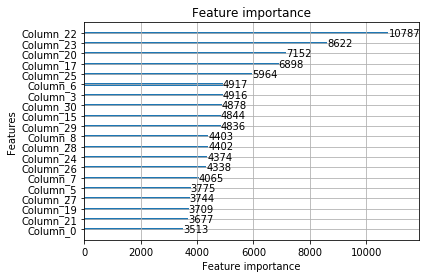

In [372]:
lgb.plot_importance(clf, max_num_features=20)

In [270]:
df.iloc[22]

AttributeError: iloc not found

In [108]:
import pickle
with open("test_pred_prob2.pkl", 'wb') as f:
    pickle.dump(test_pred_prob, f)

In [109]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

In [110]:
for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

In [243]:
sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])

In [244]:
sub_example = sub_example.merge(sub, on='listing_id', how='left')

In [245]:
def add_1_month(s):
    s = s.strftime('%F')
    y, m, d = str(s).split('-')
    y = int(y)
    m = int(m)
    d = int(d)
    m = m + 1
    if m == 13:
        m = 1
        y = y + 1
    if m in [4,6,9,11]:
        if d == 31:
            d = 30
    if m == 2:
        if d in [29, 30, 31]:
            if y in [2012, 2016]:
                d = 29
            else:
                d = 28
    return datetime.datetime.strptime(str(y)+'-'+str(m)+'-'+str(d), '%Y-%m-%d')

In [246]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [247]:
sub_example['due_date'] = sub_example['auditing_date'].progress_apply(add_1_month)

In [248]:
sub_example.head()

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
0,5431438,4.3309,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303
1,5431438,4.3309,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303
2,5431438,4.3309,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303
3,5431438,4.3309,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303
4,5431438,4.3309,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303


In [249]:
sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

In [250]:
sub_example.head()

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32,days
0,5431438,4.3309,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303,31
1,5431438,4.3309,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303,30
2,5431438,4.3309,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303,29
3,5431438,4.3309,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303,28
4,5431438,4.3309,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.731088,0.076187,0.02968,0.019303,0.01095,0.008101,0.006172,0.00483,0.003713,0.003405,0.002265,0.001527,0.001796,0.00151,0.0011,0.001844,0.001026,0.000965,0.000908,0.00079,0.000749,0.00059,0.001185,0.000657,0.000482,0.000422,0.000796,0.000489,0.000822,0.00051,0.00045,0.000386,0.085303,27


In [251]:
test_prob = sub_example[prob_cols].values

In [252]:
test_labels = sub_example['days'].values

In [253]:
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]

In [254]:
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob

In [255]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv", index=False)

In [256]:
sub_example['prob'] = test_prob

In [257]:
threshold_up = 0.7
id_with_highpro = sub_example[sub_example['prob']>=threshold_up]['listing_id']

In [258]:
sub_example.loc[sub_example['listing_id'].isin(id_with_highpro.values),'repay_amt']=0

In [259]:
sub_example['repay_amt']= sub_example.apply(lambda x:x['repay_amt'] if x['prob']<threshold_up else x['due_amt'],axis=1)

In [260]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_0_{threshold_up}.csv", index=False)

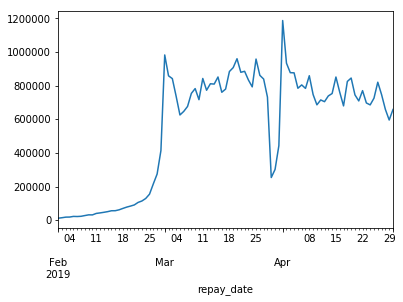

In [242]:
pd.set_option('display.max_rows', 100)
sub_example.groupby('repay_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

In [225]:
def alter(df, date, a):
    """
    data就是要增加的日期
    a就是这天增加的比例
    """
    if date not in df['repay_date'].values:
        return df
    else:
        dates = df['repay_date'].tolist()
        dates.remove(date)
        df = df.set_index('repay_date')
        b = df.loc[date, 'repay_amt'] * a
        df.loc[date, 'repay_amt'] += b
        df.loc[dates, 'repay_amt'] -= b / len(dates)
        df.reset_index(inplace=True)
        return df

In [218]:
sub_example_1 = sub_example.copy()

In [219]:
sub_example_1['repay_date']=sub_example_1['repay_date'].astype(str)

In [238]:
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-29", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-30", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-31", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]

In [240]:
sub_example_1.to_csv("sub_ex.csv",index=False)

# 下面这行的结果告诉我一下

In [130]:
#df_bkup = sub_example.copy()

In [131]:
#sub_example['prob'] = test_prob 

In [132]:
#sub_example.sort_values(by='prob',ascending = False).drop_duplicates('listing_id').reset_index(drop=True).prob.describe()

In [133]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)


In [134]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example_fin=sub_example[['listing_id', 'repay_date', 'repay_amt']]
#    sub_example_fin[sub_example_fin['repay_amt']!=0].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)